<br>
<p>
    Weblog Dataset is used from the following website:<a>https://www.kaggle.com/shawon10/web-log-dataset/data</a>.
    <br>
    The dataset is stored in weblog.csv file in <b><i>Data</i></b> dir 
    <br>
    Clean and reformatted file is store in log.sqlite file in <b><i>Output</i></b> dir
</p>

<br>
<h5>Libraries used</h5>

In [52]:
# Libraries used this TMA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import create_engine , Column , String ,Integer , Date , Time ,extract , desc , distinct ,func 
from sqlalchemy.orm import Session 
import calendar

<br>
<h4>Different values for each column</h4>

<p>For each feature number of unique values are as following:</p>
<ul>
    <li>IP    &emsp;&emsp;&nbsp;= 16</li>
    <li>Time  &emsp;= 7307</li>
    <li>URL   &emsp;&nbsp;= 314</li>
    <li>Staus&emsp;=13</li>
</ul>
<p>
Overall, there are 218 useless rows. To be specific, there are 11 unique useless values for IP column, 8 for Status column, 22 for URL column and 9 for Time column which tallies up to 218 rows of useless values.
</p>

<h4> Data Cleaning</h4>

<p>>>> Removing the useless item and reformat the dataset in the following columns: <b>
    ‘IP’, ‘date’, ‘time’, ‘request type’, ‘URL’, ‘status code’. </b></p>

In [53]:
df = pd.read_csv('./Data/weblog.csv')
df = df.loc[df['IP'].str.startswith('1')].reset_index().drop('index',axis=1)
df = pd.concat([
    pd.DataFrame(df['Time'].str[1:].str.strip().str.split(':',n=1).to_list(),columns=['Date','Time']),
    df.drop('Time',axis=1)
],axis=1)
df['Date'] , df['Request_Type'] , df['Staus'] , df['Time'] , df['URL']= pd.to_datetime(df['Date']) \
                                                                , df['URL'].str.split().str[0].str.strip()\
                                                                , df["Staus"].astype('int')\
                                                                , pd.to_datetime(df['Time'],format= '%H:%M:%S' ).dt.time\
                                                                ,df['URL'].str.split().str.get(1)
df.rename(columns={"Staus":'Status_Code'},inplace=True)
df = df.sort_values(by='Date').reset_index(drop=True)
print("\nCleaned DataFrame:\n")
display(df.head(3))


Cleaned DataFrame:



,Date,Time,IP,URL,Status_Code,Request_Type
0,2017-11-07,23:59:19,10.130.2.1,/,200,GET
1,2017-11-07,23:59:19,10.130.2.1,/,200,GET
2,2017-11-08,01:36:22,10.128.2.1,/,302,GET


<br>
<h4>Storing Clean Dataset</h4>
<p>
    Applied Python ORM(s) to store the cleaned log file.    
</p>

In [54]:
# Engine & Base creation
engine = create_engine('sqlite:///./Output/log.sqlite')
Base   = declarative_base()
engine.execute('DROP TABLE IF EXISTS weblog')

# ORM CLASS TO STORE weblog DATAFRAME
class WebLog(Base):
    
    __tablename__ = 'weblog'
    
    id           = Column(Integer,primary_key=True)
    date         = Column(Date)
    time         = Column(Time)
    ip           = Column(String(45) , nullable=False)
    url          = Column(String,nullable=False)
    status_code  = Column(Integer)
    request_type = Column(String(8) , nullable = False)
    
    def __repr__ (self):
        return  f"ID {self.id:<5} | IP {self.ip}"

Base.metadata.create_all(engine)
# SESSION
session = Session(bind=engine)
# STORES THE WebLog class instances
store_instances = []
for i in range(len(df)):
    row = df.iloc[i]
    instance = WebLog(
        date = row['Date'],
        time = row['Time'],
        ip   = row['IP'],
        url  = row['URL'],
        status_code  = row['Status_Code'].item(),
        request_type = row['Request_Type']
    )
    store_instances.append(instance)

session.add_all(store_instances)
session.commit()
session.close()
engine.dispose()

<br>
<h4>Important Queries - <u>without pandas</u></h4>
<br>
<p>
    >>> Querying Top 3 frequent <b>IP addresses</b> for each year
</p>

In [55]:
engine  = create_engine('sqlite:///./Output/log.sqlite')
session = Session(engine)

top_three_years = []
for year in ['2017','2018']:
    temp_lis =session.query(WebLog.ip,func.count(WebLog.ip).label('IP_Count_Per_Year'))\
                  .filter(extract('year',WebLog.date)==year)\
                  .group_by(WebLog.ip)\
                  .order_by(desc('IP_Count_Per_Year')).limit(3).all()
    top_three_years.append((year,temp_lis))

print('Top 3 frequent IP addresses for each year')
for year , content in top_three_years:
    print(f'\nFor Year {year}:')
    print(f"IP\t    Count")
    for ip in content:
        print(f"{ip[0]}  {ip[1]}")

Top 3 frequent IP addresses for each year

For Year 2017:
IP	    Count
10.131.0.1  2113
10.130.2.1  1956
10.128.2.1  1836

For Year 2018:
IP	    Count
10.128.2.1  2421
10.130.2.1  2100
10.131.0.1  2085


<br>
<p>
    >>> Top 3 months which incur more <b>404</b> error code.
</p>

In [56]:
top_three_months=session.query(extract('month',WebLog.date).label('Month'),func.count(WebLog.status_code)\
              .label('Status404_Count_Per_Month'))\
              .filter(WebLog.status_code == 404)\
              .group_by('Month')\
              .order_by(desc('Status404_Count_Per_Month'))\
              .limit(3).all()

print('Top 3 months which incur more 404 error code\n')
print("Month\tMonth_Name   Count")
for content in top_three_months:
    print(f"{content[0]:<7} {calendar.month_name[content[0]]:<12} {content[1]}")

Top 3 months which incur more 404 error code

Month	Month_Name   Count
11      November     139
12      December     67
2       February     34


<br>
<p>
    >>> The average number of <b>GET</b> & <b>POST</b> requests on a monthly base
</p>

In [57]:
sub_q_iii = session.query(WebLog.request_type,extract('month',WebLog.date).label('Month'),func.count(WebLog.request_type).label('Count'))\
                .filter(WebLog.request_type.in_(['GET','POST']))\
                .group_by(WebLog.request_type,'Month').subquery()
avg_get_post = session.query(sub_q_iii.columns.request_type,func.avg(sub_q_iii.columns.Count))\
                      .group_by(sub_q_iii.columns.request_type).all()

print('The average number of GET & POST requests on a monthly base')
print('\nType   Count')
for req , count in avg_get_post:
    print(f"{req:<4}   {count}")
    
session.close()
engine.dispose()

The average number of GET & POST requests on a monthly base

Type   Count
GET    3019.6
POST   136.4


<br>
<h4>Important Queries - <u>with pandas</u></h4>
<br>
<p>
    >>> Querying Top 3 frequent <b>IP addresses</b> for each year
    >>> Top 3 months which incur more <b>404</b> error code.
    >>> The average number of <b>GET</b> & <b>POST</b> requests on a monthly base
</p>

In [58]:
df = pd.read_sql('weblog',con='sqlite:///./Output/log.sqlite',index_col=['id'])
df.rename(columns=str.upper,inplace=True)

# Top THREE (3) frequent IP addresses for each year.
frequent_ip_df  = df['IP'].groupby(df['DATE'].dt.year).apply(lambda s : s.value_counts().head(3)).to_frame()
frequent_ip_df.rename(columns={"IP":"COUNT"},inplace=True)
frequent_ip_df.index.names = ['YEAR','IP']

# Top THREE (3) months which incur more 404 error code.

error_404_df  = df.loc[df['STATUS_CODE']==404]
error_404_df  = error_404_df.groupby(error_404_df['DATE'].dt.month).size()\
                .sort_values(ascending=False).head(3).to_frame()\
                .rename(columns={0:"COUNT"})
error_404_df.index = pd.MultiIndex.from_arrays([error_404_df.index.values\
                                                ,error_404_df.index.map(lambda m : calendar.month_name[m]).values])
error_404_df.index.names=['MONTH','MONTH_NAME']

# The average number of GET & POST requests on a monthly base.

avg_GP_df = df.loc[(df['REQUEST_TYPE'] == 'GET') | (df['REQUEST_TYPE'] == 'POST')]
avg_GP_df = avg_GP_df['REQUEST_TYPE'].groupby(avg_GP_df['DATE'].dt.month).value_counts().unstack().mean()\
                .to_frame().rename(columns={0:'AVG_PER_MONTH'})

print("Top THREE (3) frequent IP addresses for each year:")
display(frequent_ip_df)
print("\nTop THREE (3) months which incur more 404 error code:")
display(error_404_df)
print("\nThe average number of GET & POST requests on a monthly base:\n")
display(avg_GP_df)

Top THREE (3) frequent IP addresses for each year:


COUNT
YEAR IP               
2017 10.131.0.1   2113
     10.130.2.1   1956
     10.128.2.1   1836
2018 10.128.2.1   2421
     10.130.2.1   2100
     10.131.0.1   2085


Top THREE (3) months which incur more 404 error code:


,,COUNT
MONTH,MONTH_NAME,
11,November,139
12,December,67
2,February,34



The average number of GET & POST requests on a monthly base:



,AVG_PER_MONTH
REQUEST_TYPE,
GET,3019.6
POST,136.4


<br>
<h4> 
    Listing the content that cannot be found by requests.
</h4>

In [59]:
def get_content(df):
    return df.loc[df['STATUS_CODE'].between(400,499)]['URL'].unique()
print('\nContent that cannot be found by requests:\n')
for content in get_content(df):
    print(content)


Content that cannot be found by requests:

/robots.txt
/djs/vendor/bootstrap-datetimepicker.js
/favicon.ico
/css/bootstrap.min.css.map


<br>
<h4>
    Listing out the content that causes the highest number of client errors.
</h4>

In [60]:
def generate_df(df):
    
    error_df         = df[df['STATUS_CODE'].between(400,499)]
    mode_cont        = error_df['URL'].mode().to_list()
    mode_error_df    = error_df[error_df['URL'].isin(mode_cont)].reset_index().drop('id',axis=1)
    df_error_top1    = mode_error_df[["DATE",'IP','URL']].drop_duplicates()\
                                                         .reset_index(drop=True)
    return df_error_top1

df_error_top1 = generate_df(df)
display(df_error_top1.head())

,DATE,IP,URL
0,2017-11-08,10.131.0.1,/robots.txt
1,2017-11-08,10.128.2.1,/robots.txt
2,2017-11-08,10.129.2.1,/robots.txt
3,2017-11-09,10.129.2.1,/robots.txt
4,2017-11-09,10.130.2.1,/robots.txt


<br>
<h4>
    Listing out the content that causes the highest number of client errors.
    <br>
    >>> with the IP address occurs continuously across a period of 3 days. 
</h4>

In [61]:
def consecutive_ip(df):
    ip_list       = df_error_top1['IP'].unique()
    df_error_top2 = df_error_top1.groupby('IP')['DATE'].value_counts()\
                                                        .to_frame()\
                                                        .rename(columns={'DATE':"COUNT"})
    store_ip      = []

    for ip in ip_list:
        ser = df_error_top2.loc[ip]['COUNT'].asfreq("D").rolling(3).sum()
        if (ser == 3).any():
            first_i = ser[ser==3].index[0]
            store_ip.append((first_i- pd.offsets.Day(2),first_i,ip))

    consecutive_df = pd.DataFrame(store_ip)\
                        .rename(columns={0:"START_DATE",1:"END_DATE",2:'CONSECUTIVE_IP'})\
                        .sort_values(by='START_DATE').reset_index(drop=True)
    unique_ip      = consecutive_df['CONSECUTIVE_IP'].unique()
    return consecutive_df,unique_ip
df_error_top1 = generate_df(df)
consecutive_df , ip_address = consecutive_ip(df_error_top1)
print("\n\nIP Addres that have Occured continuously across a period of 3 days\n")
for ip in ip_address:
    print(f"-> {ip}")
print('\n')
print("Data Frame Consisting IP address first occurrences, continuously across a period of 3 days\n")
display(consecutive_df)



IP Addres that have Occured continuously across a period of 3 days

-> 10.128.2.1
-> 10.129.2.1
-> 10.131.2.1
-> 10.131.0.1
-> 10.130.2.1


Data Frame Consisting IP address first occurrences, continuously across a period of 3 days



,START_DATE,END_DATE,CONSECUTIVE_IP
0,2017-11-08,2017-11-10,10.128.2.1
1,2017-11-08,2017-11-10,10.129.2.1
2,2017-11-09,2017-11-11,10.131.2.1
3,2017-11-14,2017-11-16,10.131.0.1
4,2017-12-12,2017-12-14,10.130.2.1


<br>
<h4>
    Number of redirect requests for each month and list out the Top 5 months.
</h4>

In [62]:
def redirect_req(df):
    new = df['DATE'].dt.month.value_counts().\
                    to_frame().\
                    rename(columns={"DATE":"COUNT"}).\
                    head(3)
    new.index = pd.MultiIndex.from_arrays([new.index.values,new.index.map(lambda m : calendar.month_name[m]).values])
    new.index.names = ['MONTH','MONTH_NAME']
    return new

# Data Frame which only contains data for redirect requests
redirect_df = df.loc[df['STATUS_CODE'].between(300,399)]
display(redirect_req(redirect_df))

,,COUNT
MONTH,MONTH_NAME,
1,January,2045
11,November,1509
12,December,383


<br>
<h4>
    For the month incurs the most redirect requests, determining the number of redirect
    requests for each date
</h4>

C:\Anaconda\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


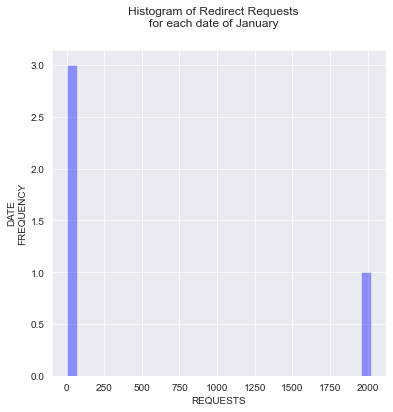

In [63]:
def highest_redirect(df):
    #Gets me the month with highest redirect requests
    highest_reqmonth = redirect_req(df).head(1).index[0][0]
    #Filters the data frame where the month is equal to the month with highest redirect requests
    new  = df.loc[df['DATE'].dt.month == highest_reqmonth].reset_index().drop('id',axis=1)
    #calculate the number of redirect requests for each date.
    new_ = new['DATE'].value_counts()\
                      .to_frame()\
                      .rename(columns={'DATE':"REQUESTS"})
    new_.index.names = ['DATE']
    #Plotting Section
    sns.set_style('darkgrid')
    fig = plt.figure(figsize=(6,6))
    fig.suptitle(f'Histogram of Redirect Requests\nfor each date of {calendar.month_name[highest_reqmonth]}')
    axes = sns.distplot(new_['REQUESTS'],kde=False,bins=30,color='blue')    
    axes.set_ylabel("DATE\nFREQUENCY")
    fig.add_axes(axes)
    plt.show()
    return fig , new_

# Data Frame which only contains data for redirect requests
redirect_df = df.loc[df['STATUS_CODE'].between(300,399)]
fig_ii , highestPerDate_df =  highest_redirect(redirect_df)

<br>
<h4>
    For the month incurs the most redirect requests,analyze the pattern of when does the redirect requests happen along a
    day
</h4>

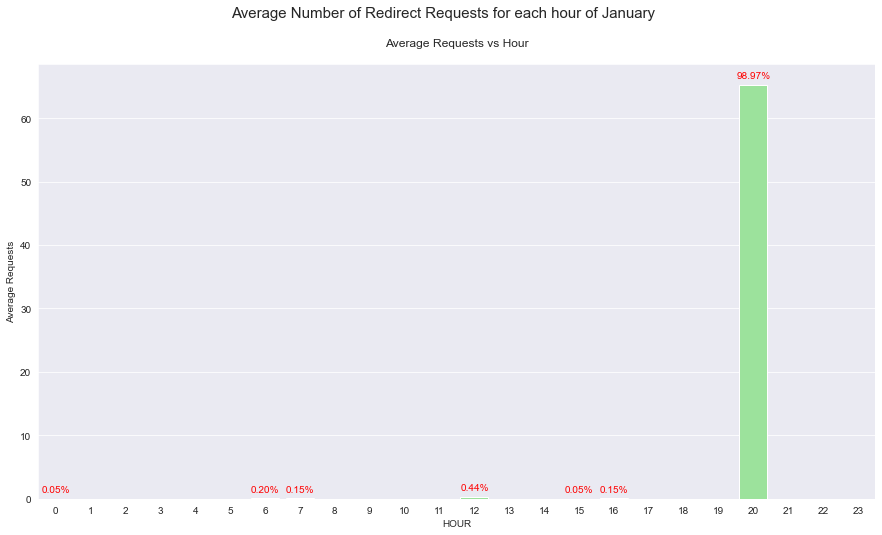


My brief findings after analysing the graph:


From the graph plotted it is evident that nearly most of the redirect requests that took place throughout the 
month of January (where most redirect requests occurred), they took place when it was it was 20 hour meaning
between 8pm- 9pm. 98.97% requests for a day were executed during 20th hour of the day for the month of January. 



In [64]:
def hourly_redirect(df):
    #Gets me the month with highest redirect requests
    highest_reqmonth = redirect_req(df).head(1).index[0][0]
    #Filters the data frame where the month is equal to the month with highest redirect requests
    new  = df.loc[df['DATE'].dt.month == highest_reqmonth].reset_index().drop('id',axis=1)
    #Calculate the redirect requests that happen each hour
    hour_df = new['TIME'].apply(lambda t : t.hour)\
                         .value_counts()\
                         .sort_index()\
                         .reset_index()\
                         .rename(columns={'TIME':'COUNT','index':'HOUR'})     
    #Calculate the average requests that happen for each hour across 31 days of January 
    #and assigns the column 'AVG_COUNT_31' to hour_df
    hour_df['AVG_COUNT_31'] = hour_df['COUNT'] / 31
    #Make sure that there are 24 hours rows in the dataframe
    hour_df = hour_df.set_index("HOUR").reindex(np.arange(24)).reset_index().fillna(0)
    #Plotting section
    fig  = plt.figure(figsize=(15,8)) #(!ZOOM OUT TO PROPERLY VIEW THE GRAPH)
    fig.suptitle("Average Number of Redirect Requests for each hour"\
                 f" of {calendar.month_name[highest_reqmonth]}",fontsize=15,va='top')
    axes = sns.barplot(x='HOUR',y='AVG_COUNT_31',data=hour_df,color='lightgreen')
    axes.set_title("Average Requests vs Hour\n")
    axes.set_ylabel('Average Requests')   
    total = hour_df['AVG_COUNT_31'].sum()
    #Style each bar in bar plot with respective percentage value, where each hour has value more than 0
    for i,p in enumerate(axes.patches):
        height = hour_df.iloc[i]['AVG_COUNT_31']
        if height:
            axes.text(p.get_x()+p.get_width()/2.,
                    height+1,
                    '{:1.2f}%'.format((height/total)*100),
                    ha="center",color='red')     
    fig.add_axes(axes)
    plt.show()
    return fig , hour_df

# Data Frame which only contains data for redirect requests
redirect_df = df.loc[df['STATUS_CODE'].between(300,399)]
fig_iii , hour_df = hourly_redirect(redirect_df)
# BRIEF ANALYSIS
print("\nMy brief findings after analysing the graph:\n")
print("""
From the graph plotted it is evident that nearly most of the redirect requests that took place throughout the 
month of January (where most redirect requests occurred), they took place when it was it was 20 hour meaning
between 8pm- 9pm. 98.97% requests for a day were executed during 20th hour of the day for the month of January. 
""")